In [1]:
import numpy as np
import pandas as pd

import pickle
import random
import os
import time
from datetime import datetime
from pathlib import Path
import glob
import json
from tqdm import tqdm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from PIL import Image
#%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle

# os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # "0" = GPU_on, "-1" = GPU_off

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#%load_ext tensorboard  # extension for notebook

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


 MODELING/FITTING
- DNN XYF model (small vs large) per site: length = 1x dT
    > Train/Validation = random record split
    
=> 1 Model + 1 Scaller per site (in dictionary)

In [2]:
def load_data(site_id, fraction_bssid, data_file="10k_mix-counts"):
    print("Loading Data...")
    path = "./data_out/full24/"  # full24/compact24
    file_name = f"{site_id}_{data_file}.pkl"
    
    f_list = features_list(site_id, fraction_bssid)

    return f_list, pickle.load(open(path+file_name, "rb"))[f_list]

def features_list(site_id, fraction_bssid, bssid_mode="weight"):
    
    train_bssid = pickle.load(open("./data_out/train_24IDs_standardF_bssid_ranks.pkl", "rb"))
    test_bssid = pickle.load(open("./data_out/test_bssid_ranks.pkl", "rb"))

    if fraction_bssid <= 1:
        _train_bssid = train_bssid[bssid_mode][site_id].bssid.tolist()
        _test_bssid = test_bssid[bssid_mode][site_id].bssid.tolist()
        _mix = list(set(_train_bssid) & set(_test_bssid))
        _list = _mix[:int(fraction_bssid*len(_mix))]
    else:
        _train_bssid = train_bssid[bssid_mode][site_id].bssid.tolist()
        _test_bssid = test_bssid[bssid_mode][site_id].bssid.tolist()
        _mix = list(set(_train_bssid) & set(_test_bssid))
        _list = _mix[:int(fraction_bssid)]

    _list_d = []
    for record in _list:
        _list_d.append(record)
        _list_d.append(record+"_D")
    _list_d += ["x", "y", "f", "m", "r", "trace"]
        
    return _list_d

def preprocess_data(featured_data, data_fraction=1, delay_lim=1000, rssi_lim=-94,  random_state=123):
    print(f"Processing Data of shape {featured_data[1].shape}...")

    raw = featured_data[1]
    
    # split train/test by number of group-traces (may not be correct for number of points which is variable from trace to trace)
    # collecting indeces for train/test split based on "traceid"
    test_fraction = 0.05
    
    t_list = featured_data[1]["trace"].unique()
    t_list_s = t_list[shuffle(list(range(len(t_list))))]
    train_traces = list(t_list_s[:int((1-test_fraction)*len(t_list_s))])
    test_traces = list(t_list_s[int((1-test_fraction)*len(t_list_s)):])

    gr = featured_data[1].groupby("trace")
    for i, trace in enumerate(train_traces):
        if i == 0:
            inds_train = gr.groups[trace]
        else:
            inds_train = inds_train.append(gr.groups[trace])

    for i, trace in enumerate(test_traces):
        if i == 0:
            inds_test = gr.groups[trace]
        else:
            inds_test = inds_test.append(gr.groups[trace])
            
    inds_train = shuffle(inds_train, random_state=random_state)
    inds_test = shuffle(inds_test, random_state=random_state)
    #####################################################################
    
    _ = raw.pop("trace")
    
    y_x = raw.pop("x")
    y_y = raw.pop("y")
    
    x_r = raw.pop("r")
    x_m = raw.pop("m")
    x_f = raw.pop("f")
    
    x = raw
###############################################
    x[x > delay_lim] = delay_lim
    x[x < rssi_lim] = rssi_lim
###############################################
    
    x = pd.concat([x, x_r, x_m], axis=1)

    encoder = LabelBinarizer()#OneHotEncoder(sparse=False)
    x_f = encoder.fit_transform(x_f)
    
    x = np.concatenate((x, x_f), axis=1)
    y = pd.concat([y_x, y_y], axis=1).to_numpy()
        
    # split train/test by corresponding indices
    train_x, train_y, val_x, val_y = x[inds_train], y[inds_train], x[inds_test], y[inds_test]
    
    train_y_x, train_y_y = np.array(train_y)[:, 0], np.array(train_y)[:, 1]
    val_y_x, val_y_y = np.array(val_y)[:, 0], np.array(val_y)[:, 1]
        
    scaler = StandardScaler()  # RobustScaler()  /StandardScaler()/ MinMaxScaler
    train_x = scaler.fit_transform(train_x)
    val_x = scaler.transform(val_x)
        
    return featured_data[0][:-6], scaler, encoder, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y
        

def save_models(models24, models="models24_bssid10k_SP_count_mix"):
    print("Saving Models...")
    
    idx = int(time.time())
    model_name = f"{models}_{idx}/"
    model_path = "./saved_models/"+ model_name

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    for site_id in tqdm(models24.keys()):

        models24[site_id][3].save(model_path + site_id)
        with open(model_path + site_id + f"/features_list.pkl", "wb") as f:
            pickle.dump(models24[site_id][0], f)
        with open(model_path + site_id + f"/scaler.pkl", "wb") as f:
            pickle.dump(models24[site_id][1], f)
        with open(model_path + site_id + f"/f_binarizer.pkl", "wb") as f:
            pickle.dump(models24[site_id][2], f)
            
def calculate_global_metrics(comparison):

    train_mae = 0
    val_mae = 0

    for comparison_train, comparison_val in comparison:

        train_mae += comparison_train.mean_abs_error[comparison_train.index[-1]]
        val_mae += comparison_val.mean_abs_error[comparison_val.index[-1]]

    comp_length = len(comparison)
    
    train_mae /= comp_length
    val_mae /= comp_length

    print(f"Global Train/Validation MAE: {train_mae}/{val_mae}")
            
def xy_loss_metric(y_true, y_pred):
    e_xy = tf.sqrt(tf.square(y_true[:, 0] - y_pred[:, 0]) +  tf.square(y_true[:, 1] - y_pred[:, 1])) 
    return tf.reduce_mean(e_xy, axis=-1)

def xy_loss_metric_mse(y_true, y_pred):
    e_xy = tf.square(y_true[:, 0] - y_pred[:, 0]) +  tf.square(y_true[:, 1] - y_pred[:, 1]) 
    return tf.sqrt(tf.reduce_mean(e_xy, axis=-1))

def DNN(site_id, train_x, val_x, train_y, val_y, w_f=10, drop=0.1, learning_rate=0.005, epochs=200, batch=6): 
    
    epoch_iterations = 15
    
    features_count = train_x.shape[1]
    targets_count = train_y.shape[1]
    records_num = train_y.shape[0]
    
    print(f"Fitting Model with {round(100*train_y.shape[0]/(val_y.shape[0]+train_y.shape[0]), 1)}% train/validation split...")
    print("----------------------------------------------------------------------------------------------------")
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)  # "adam"
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-20)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
        
    if batch==0:
        batch = int(np.log2(records_num/epoch_iterations))
        
    METRICS = [
        #tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)
        xy_loss_metric,
        #tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)
    ]       
    
    MODEL_NAME = f"Site-{site_id}_bssid-f{features_count}_L5x{w_f}_LR{learning_rate}_ep{epochs}_bch{batch}_{int(time.time())}"
    tensorboard = TensorBoard(log_dir=f"log/Neurals/{MODEL_NAME}", histogram_freq=1)
            
    model = keras.Sequential([
        #layers.BatchNormalization(input_shape=(features_count,)),
        
        #layers.Dense(int(features_count*w_f if w_f < 1 else w_f), activation="relu"),
        layers.Dense(int(features_count*w_f if w_f <= 1 else w_f), activation="relu", input_shape=(features_count,)),
        layers.Dropout(drop),       
        layers.BatchNormalization(),
        
        layers.Dense(int(features_count*w_f if w_f <= 1 else w_f), activation="relu"),  # 0.5
        layers.Dropout(drop),
        layers.BatchNormalization(),
        
        layers.Dense(int(features_count*w_f if w_f <= 1 else w_f), activation="relu"),  # 0.5
        layers.Dropout(drop),
        layers.BatchNormalization(),
        
        layers.Dense(int(features_count*w_f if w_f <= 1 else w_f), activation="relu"),  # 0.25
        layers.Dropout(drop),
        layers.BatchNormalization(),
        
        layers.Dense(int(features_count*w_f if w_f <= 1 else w_f), activation="relu"),  # 0.25
        #layers.Dropout(drop),
        #layers.BatchNormalization(),
                        
        layers.Dense(targets_count)
    ])

    model.compile(optimizer=optimizer,
                  #loss="mae",
                  #loss="mse",
                  #loss=xy_loss_metric,#"mse",
                  loss=xy_loss_metric_mse,
                  metrics=METRICS)
    
    #model.summary()  
    
    fit = model.fit(train_x, train_y,
                    validation_data=(val_x,  val_y),
                    batch_size=2**batch,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[tensorboard,  reduce_lr]#, earlystop]
                   )
        
    #fit_progress = pd.DataFrame(fit.history)
    #fit_progress.loc[:, ["accuracy", "val_accuracy"]].plot()
    #fit_progress.loc[:, ["loss", "val_loss"]].plot()

    return model

Working on #1: Site-5d27075f03f801723c2e360f
Loading Data...
Processing Data of shape (73141, 2474)...
Fitting Model with 94.0% train/validation split...
----------------------------------------------------------------------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach th

,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000
mean,157.822963,121.975244,157.808670,121.656212,9.771416,9.912156,7.740997
std,77.641067,37.849275,78.882401,36.310127,11.661161,12.208865,4.481039
min,26.116701,12.371694,21.489002,16.234091,0.005157,0.002667,0.003043
25%,75.299122,92.451869,71.016914,93.676071,2.884713,2.678039,3.899080
50%,193.417962,118.714761,197.329865,119.356979,6.510862,5.981076,7.655927
75%,220.390060,152.163734,219.083481,151.269363,12.864630,12.756907,11.590648
max,267.280150,211.099505,264.457581,201.014420,195.228354,82.464026,15.504854


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1,190.185184,166.152905,217.109711,154.209564,26.924527,11.943341,0.009711
2,187.854588,137.022816,208.189697,132.620026,20.335109,4.402790,0.014422
11,145.933510,131.153819,170.268112,126.721878,24.334602,4.431941,0.042639
13,260.107471,153.457773,238.405197,160.960892,21.702274,7.503118,0.049902
15,183.791380,104.116844,191.445694,125.171036,7.654314,21.054192,0.056695
...,...,...,...,...,...,...,...
4384,63.769960,82.912091,34.699924,74.434723,29.070035,8.477368,15.412432
4395,64.082686,78.058696,29.055719,73.630920,35.026967,4.427776,15.442191
4397,221.499311,115.674641,216.986099,136.267700,4.513212,20.593059,15.451183
4401,263.170477,184.960502,224.969559,176.068924,38.200918,8.891578,15.466935


Working on #2: Site-5dc8cea7659e181adb076a3f
Loading Data...
Processing Data of shape (57849, 4934)...
Fitting Model with 95.2% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #2: Site-5dc8cea7659e181adb076a3f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,149.793276,114.666012,149.656693,114.608986,7.205022,4.528570,4.730635
std,63.876363,36.370203,64.873558,36.122002,13.641729,3.963560,2.789210
min,14.016070,50.014175,14.717218,51.862133,0.001021,0.001719,0.003532
25%,94.348164,89.859243,88.771870,90.019123,2.283630,1.580495,2.271206
50%,156.679727,109.080505,152.921600,109.435211,4.795380,3.454142,4.803791
75%,210.682097,132.843805,213.553421,135.415352,8.065273,6.255732,7.161007
max,246.626370,246.777212,242.745499,240.422134,160.920934,27.623174,9.467504


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
3,53.806135,82.115768,81.117615,90.959419,27.311479,8.843651,0.018511
49,163.943325,144.257054,203.441162,137.773529,39.497837,6.483525,0.163088
84,163.603871,144.803324,200.464218,139.277054,36.860347,5.526270,0.270906
90,158.652712,153.832881,199.774811,151.299759,41.122098,2.533123,0.294275
121,47.943214,81.206510,77.551376,88.977554,29.608162,7.771045,0.383175
...,...,...,...,...,...,...,...
2444,51.154080,81.568245,79.219627,89.920151,28.065547,8.351906,8.440065
2497,162.959044,145.903027,200.614059,139.399582,37.655015,6.503445,8.597154
2664,51.763304,81.711860,79.843597,90.263451,28.080294,8.551591,9.096074
2696,165.079198,139.823216,189.371078,138.510208,24.291881,1.313008,9.195377


Working on #3: Site-5dbc1d84c1eb61796cf7c010
Loading Data...
Processing Data of shape (61727, 7194)...
Fitting Model with 93.8% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #3: Site-5dbc1d84c1eb61796cf7c010


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3857.000000,3857.000000,3857.000000,3857.000000,3857.000000,3857.000000,3857.000000
mean,131.511483,144.062503,131.259323,144.133286,5.832467,5.460437,4.274238
std,53.356816,63.229203,51.170074,62.878750,6.037442,5.429691,2.489141
min,24.261068,41.367256,26.679129,42.335461,0.003010,0.001121,0.000607
25%,90.171214,103.675746,88.870064,104.299339,1.770335,1.945712,2.106629
50%,136.526637,132.486246,137.424011,132.230362,4.069054,4.156719,4.312393
75%,174.604016,162.144780,169.340439,165.751373,7.970461,7.778054,6.395082
max,232.436871,350.069926,241.779434,348.090393,59.842136,63.782141,8.642276


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
16,34.227527,80.721689,55.966133,80.763458,21.738606,0.041769,0.039297
63,188.781107,137.511683,167.448685,152.736664,21.332422,15.224981,0.135683
148,25.676560,99.209840,46.222958,109.677078,20.546398,10.467238,0.306665
182,31.928738,72.785543,52.989704,72.834991,21.060966,0.049448,0.379699
252,188.034097,138.715858,167.632233,152.390350,20.401865,13.674492,0.522707
...,...,...,...,...,...,...,...
3725,171.094224,152.679414,146.414963,171.334320,24.679262,18.654907,8.325407
3755,29.045964,106.440117,61.379349,117.989380,32.333384,11.549263,8.389234
3814,175.549156,143.750971,145.361359,102.310265,30.187797,41.440706,8.536734
3821,192.678507,132.492215,167.248520,152.919983,25.429987,20.427768,8.559049


Working on #4: Site-5da138b74db8ce0c98bd4774
Loading Data...
Processing Data of shape (56668, 4722)...
Fitting Model with 94.5% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #4: Site-5da138b74db8ce0c98bd4774


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000
mean,113.905287,104.323994,113.056694,104.595680,5.404672,5.898155,4.393001
std,41.431123,63.056993,40.373631,62.637909,4.470587,5.972853,2.584258
min,5.142299,24.225888,13.581852,27.068148,0.000187,0.008314,0.004709
25%,95.833281,71.565152,96.577839,73.501667,1.912042,1.970185,2.150375
50%,118.860762,86.007679,117.160538,86.169880,4.246559,4.337577,4.376089
75%,130.697375,112.933891,129.590317,111.268890,7.667116,7.645957,6.616649
max,213.356200,322.800380,209.344925,317.687408,25.799302,50.372741,8.905587


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
36,84.904547,50.571343,89.565842,92.676292,4.661294,42.104950,0.085051
181,84.455900,50.710783,88.839539,94.208656,4.383638,43.497874,0.454104
272,117.262411,169.370071,138.510361,157.127731,21.247950,12.242340,0.696144
276,123.657940,88.379412,124.461632,65.599220,0.803691,22.780191,0.712671
296,135.318767,90.956591,141.961807,67.602699,6.643040,23.353891,0.767597
...,...,...,...,...,...,...,...
3040,93.160575,45.270996,93.693764,79.476173,0.533188,34.205177,8.695724
3056,136.582967,86.169005,144.812607,54.899311,8.229640,31.269694,8.751197
3062,51.634748,231.854804,49.784298,254.400711,1.850450,22.545907,8.772436
3102,123.828746,89.891499,111.312408,62.931984,12.516338,26.959515,8.887711


Working on #5: Site-5d2709c303f801723c3299ee
Loading Data...
Processing Data of shape (33368, 8656)...
Fitting Model with 95.1% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #5: Site-5d2709c303f801723c3299ee


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000
mean,37.635121,96.619613,37.703579,96.598381,3.147030,4.192983,2.951151
std,13.896403,69.296800,13.996327,68.472679,2.499945,4.459389,1.681618
min,2.522254,11.836680,3.964168,12.540894,0.000019,0.001213,0.001271
25%,25.242201,33.924633,25.432958,35.544857,1.186193,1.195763,1.495530
50%,41.896369,73.711248,38.954735,75.291298,2.611656,2.720865,2.996979
75%,45.788023,178.995128,47.714704,178.985569,4.643804,5.504840,4.390769
max,69.566956,218.639500,69.812920,217.929230,16.910379,26.547360,5.891065


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
1,28.404170,20.589327,24.285124,41.346035,4.119046,20.756708,0.014302
99,14.619776,21.378649,20.355152,43.018677,5.735376,21.640028,0.361982
174,19.688881,22.658417,19.683584,42.923325,0.005297,20.264907,0.640967
202,17.965626,22.433116,19.305819,44.704899,1.340192,22.271783,0.751965
288,44.647800,49.391190,45.590332,29.136078,0.942532,20.255112,1.043769
369,13.838884,21.008379,20.351509,43.025238,6.512625,22.016859,1.357993
425,28.019559,19.805843,24.945105,46.353203,3.074454,26.547360,1.583121
446,20.690911,22.772831,19.685949,42.919323,1.004962,20.146492,1.678649
651,16.838436,22.300021,19.312763,44.697094,2.474327,22.397073,2.442763
715,15.467006,20.370645,19.619183,40.734497,4.152176,20.363852,2.660918


Working on #6: Site-5da958dd46f8266d0737457b
Loading Data...
Processing Data of shape (47796, 5732)...
Fitting Model with 94.9% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #6: Site-5da958dd46f8266d0737457b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2423.000000,2423.000000,2423.000000,2423.000000,2423.000000,2423.000000,2423.000000
mean,90.480535,141.000162,89.476685,139.422974,3.818951,6.094658,3.958608
std,25.342055,60.987654,24.554825,60.934742,3.216817,8.856097,2.312143
min,51.409026,27.208363,55.183605,24.630850,0.002439,0.012305,0.000598
25%,69.757931,91.699776,70.473114,85.401367,1.527811,1.835101,1.953618
50%,86.676100,137.975261,84.343018,138.387054,2.965542,4.114985,3.911283
75%,106.435622,199.169429,105.183189,202.408417,5.203308,7.826805,5.961813
max,151.805940,246.288470,151.358429,248.201584,23.942380,100.389472,7.952618


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
30,118.465917,132.215915,111.444069,110.437653,7.021848,21.778263,0.083051
57,100.677435,125.663514,82.503021,25.274042,18.174414,100.389472,0.210328
155,115.813855,127.547929,104.669304,103.742180,11.144551,23.805749,0.545809
277,118.201670,131.811895,111.422401,110.380264,6.779269,21.431631,0.907233
312,98.422887,122.185892,89.442230,51.880505,8.980656,70.305388,1.021683
369,60.657901,240.900124,69.720078,219.210571,9.062176,21.689552,1.189892
428,120.715185,135.529574,116.103661,114.173935,4.611525,21.355639,1.361588
504,60.187442,240.552306,69.727875,219.217865,9.540433,21.334441,1.611846
514,97.491306,120.787562,89.436623,51.840961,8.054684,68.946600,1.662087
525,97.707790,121.127886,89.438354,51.858326,8.269436,69.269560,1.716581


Working on #7: Site-5d2709bb03f801723c32852c
Loading Data...
Processing Data of shape (44009, 3038)...
Fitting Model with 96.3% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #7: Site-5d2709bb03f801723c32852c


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,166.081631,181.792865,165.347000,182.818283,5.268283,4.720682,3.936579
std,34.025041,55.361509,35.462299,53.206310,6.396134,4.296651,2.287320
min,14.819731,22.826172,19.286264,44.032009,0.000505,0.001856,0.002108
25%,150.813847,179.144544,149.610283,179.070660,1.584066,1.500229,1.933743
50%,159.982489,188.517874,156.686813,190.410019,3.499129,3.703841,3.860607
75%,182.473225,211.883477,181.523090,213.282433,6.153308,6.615102,5.938551
max,265.993440,267.110780,265.475830,265.414581,53.115696,26.862639,7.879941


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
17,164.046913,181.473122,111.926048,167.575363,52.120865,13.897759,0.094496
53,238.214841,27.678853,257.383240,50.129349,19.168399,22.450495,0.252945
75,141.987747,88.309880,163.848145,91.358566,21.860398,3.048686,0.351301
77,237.971759,27.170317,257.338654,50.086670,19.366894,22.916353,0.376816
79,249.101725,34.718326,261.308380,54.901142,12.206656,20.182816,0.393226
...,...,...,...,...,...,...,...
1563,157.345210,193.140111,136.325119,181.167297,21.020091,11.972814,7.475365
1566,239.715420,22.826172,252.140594,44.032009,12.425174,21.205837,7.499084
1574,166.626480,183.644424,123.977699,168.351547,42.648780,15.292876,7.552337
1586,163.964734,183.407347,143.308350,175.731918,20.656384,7.675429,7.607864


Working on #8: Site-5d27096c03f801723c31e5e0
Loading Data...
Processing Data of shape (19337, 2072)...
Fitting Model with 94.3% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #8: Site-5d27096c03f801723c31e5e0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,66.213155,67.166026,65.876862,67.698715,2.300686,2.503691,1.872366
std,15.790651,19.823444,15.844265,20.130444,1.627652,2.123334,1.082489
min,34.066998,19.978085,34.292236,23.614183,0.000598,0.001775,0.005419
25%,52.106416,50.734323,50.663518,50.667994,0.981326,0.930413,0.941295
50%,70.079188,64.970629,69.011265,65.213840,1.983633,2.009760,1.876394
75%,78.464802,85.159002,78.209471,86.777073,3.305733,3.482570,2.791280
max,99.753560,110.266400,96.942711,107.972290,8.081418,14.183157,3.760882


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #9: Site-5a0546857ecc773753327266
Loading Data...
Processing Data of shape (26532, 4804)...
Fitting Model with 95.3% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #9: Site-5a0546857ecc773753327266


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000,1241.000000
mean,83.063415,90.322173,83.043800,91.266960,2.810794,3.498503,2.474934
std,37.824686,41.342508,38.461369,40.437668,1.983776,2.738981,1.447765
min,20.843815,8.184300,23.930670,14.001051,0.002876,0.002419,0.002239
25%,51.162831,51.940401,49.477722,53.384979,1.251843,1.343091,1.229852
50%,83.160668,90.793553,84.934685,88.651260,2.490071,2.890123,2.495857
75%,112.764516,111.885367,118.364418,112.875397,4.062020,5.072484,3.741260
max,198.368330,174.665470,203.370590,172.519852,10.278692,14.421086,4.976411


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #10: Site-5c3c44b80379370013e0fd2b
Loading Data...
Processing Data of shape (29359, 2146)...
Fitting Model with 94.3% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #10: Site-5c3c44b80379370013e0fd2b


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,207.648399,89.787212,208.631348,90.011070,4.763288,4.247439,3.617698
std,66.607475,43.676771,66.036880,43.051567,5.787339,3.357034,2.061698
min,109.142967,13.078606,108.369522,20.423573,0.001249,0.001904,0.005387
25%,158.040708,51.686832,160.131512,47.303954,1.361590,1.610175,1.845880
50%,184.643190,90.104412,185.194954,89.698616,3.158023,3.417263,3.645396
75%,246.895320,129.822135,245.007988,129.713123,6.349084,6.109782,5.435238
max,354.770260,176.210452,343.269684,168.488068,62.989314,20.636990,7.119683


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
18,173.947057,110.564737,236.936371,113.073463,62.989314,2.508726,0.112936
40,142.360886,51.446049,163.647354,51.002163,21.286468,0.443886,0.199989
72,142.072870,52.452431,163.449677,50.931118,21.376806,1.521313,0.323690
88,292.060886,131.682218,315.787354,133.547638,23.726468,1.865420,0.398762
147,292.170397,132.822259,315.757385,133.709518,23.586988,0.887259,0.663484
176,141.517134,53.863576,161.763901,46.915867,20.246767,6.947709,0.778682
265,172.559766,111.562882,224.741791,125.640335,52.182024,14.077453,1.152073
269,292.949487,136.502456,313.494385,138.345139,20.544898,1.842683,1.174427
285,173.596347,110.819209,224.750427,125.630920,51.154080,14.811711,1.260059
289,173.245258,111.089268,224.744766,125.642525,51.499509,14.553257,1.306951


Working on #11: Site-5d27097f03f801723c320d97
Loading Data...
Processing Data of shape (35121, 2234)...
Fitting Model with 92.9% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #11: Site-5d27097f03f801723c320d97


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,106.980103,168.763539,106.378128,167.226562,4.795583,5.467337,4.061832
std,54.759499,92.217203,55.303394,92.830582,4.823966,4.967313,2.322022
min,5.847549,7.493611,6.920115,10.117691,0.003433,0.006318,0.004104
25%,61.268874,95.026590,58.797638,90.604609,1.609037,2.119510,2.062216
50%,108.120996,188.221078,110.589600,187.204323,3.731828,4.440897,4.130202
75%,146.236820,244.242892,143.496010,244.429691,6.778645,7.636881,6.037730
max,216.098874,311.558100,207.600464,309.331299,85.297140,57.644166,8.014338


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
7,162.481540,120.361176,161.571747,90.742287,0.909793,29.618889,0.032995
117,166.662380,112.873566,155.459961,89.649269,11.202419,23.224297,0.379507
310,96.603140,251.823460,12.784564,271.801483,83.818576,19.978023,1.050099
363,164.607530,113.027676,165.797028,86.383682,1.189498,26.643994,1.201886
485,163.157888,119.325298,164.554565,69.500404,1.396677,49.824894,1.581597
588,96.298235,252.327841,13.285201,270.570374,83.013034,18.242533,1.946356
768,164.862030,113.188660,161.990204,55.553261,2.871826,57.635399,2.560977
816,165.645482,113.069361,161.980255,55.464806,3.665227,57.604556,2.721685
903,107.765368,202.406359,104.447891,181.679169,3.317477,20.727190,2.985090
904,163.477987,118.840201,164.584686,68.762001,1.106700,50.078200,3.005304


Working on #12: Site-5da1382d4db8ce0c98bbe92e
Loading Data...
Processing Data of shape (28975, 3568)...
Fitting Model with 94.9% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #12: Site-5da1382d4db8ce0c98bbe92e


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000
mean,124.497635,83.314051,124.323975,83.308662,5.577961,3.881020,3.860725
std,32.840113,40.584126,32.351521,40.265823,7.647012,3.217115,2.215580
min,46.878033,26.048451,43.073818,25.610008,0.004670,0.000220,0.002784
25%,100.067706,42.397754,102.823109,42.710478,1.711589,1.460915,1.965405
50%,137.407612,83.914363,138.571198,87.457840,3.527319,3.385979,3.849442
75%,148.167991,120.348196,150.995270,117.485556,6.078521,5.338854,5.870911
max,176.717207,148.111020,171.817886,148.162613,46.856506,20.854013,7.636292


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
7,166.833132,109.818905,125.322395,110.940155,41.510737,1.121251,0.043897
15,150.382729,52.325146,154.075470,31.705755,3.692741,20.619391,0.083326
35,164.576102,105.937188,122.718391,111.601715,41.857710,5.664527,0.189595
47,166.868496,107.833008,129.931870,110.349236,36.936626,2.516227,0.251905
71,175.601574,110.434804,131.599503,110.406708,44.002072,0.028097,0.367100
...,...,...,...,...,...,...,...
1292,167.004092,109.667035,142.892197,105.008316,24.111896,4.658719,6.704020
1321,163.501112,106.542700,121.740265,110.898651,41.760847,4.355951,6.840668
1325,172.972411,110.522977,138.791611,108.712036,34.180800,1.810941,6.873701
1407,175.639082,110.445302,138.743805,108.938667,36.895277,1.506635,7.224784


Working on #13: Site-5d2709b303f801723c327472
Loading Data...
Processing Data of shape (32449, 2298)...
Fitting Model with 95.3% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #13: Site-5d2709b303f801723c327472


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000
mean,125.096845,84.047893,125.708229,84.040916,3.929451,3.600950,2.994210
std,55.335805,18.375431,55.946056,18.778397,4.237408,3.258868,1.691695
min,25.023413,30.216055,22.468626,33.082237,0.002332,0.000890,0.002186
25%,88.646750,74.008468,87.006449,74.890760,1.429267,1.290307,1.533804
50%,124.623619,88.844911,126.717113,88.507008,2.802172,2.683260,2.995492
75%,179.204390,95.279245,180.982555,95.728750,5.089350,4.864558,4.424541
max,213.539020,139.044774,215.440994,137.881271,43.939797,18.951916,5.909712


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
30,108.671113,68.784332,135.113052,74.379044,26.441940,5.594712,0.126150
66,110.948463,71.173157,153.094070,80.224991,42.145607,9.051834,0.304506
159,108.319038,69.501133,134.982346,74.481476,26.663308,4.980343,0.696040
170,110.529790,64.121730,131.322189,82.529877,20.792399,18.408147,0.739334
213,109.564103,71.076275,152.933533,80.226761,43.369430,9.150486,0.895634
289,109.282485,67.400229,131.461411,75.697807,22.178926,8.297579,1.160460
362,109.860237,65.984290,131.542068,75.681976,21.681831,9.697686,1.452791
432,110.311008,64.643906,140.124466,73.830780,29.813458,9.186874,1.713840
573,110.093494,65.248813,131.618149,75.667763,21.524655,10.418950,2.297923
715,109.539999,66.719214,131.452438,75.700111,21.912439,8.980897,2.804001


Working on #14: Site-5d2709d403f801723c32bd39
Loading Data...
Processing Data of shape (23545, 3212)...
Fitting Model with 95.1% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #14: Site-5d2709d403f801723c32bd39


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,87.913553,71.348465,85.616409,75.166061,5.691948,7.139373,5.064065
std,39.720455,40.057513,43.088924,35.147823,4.872316,6.370182,2.872022
min,24.910624,0.788972,21.526133,4.702215,0.009058,0.002251,0.005860
25%,59.883326,33.640290,58.134977,50.292063,1.880413,2.391977,2.624320
50%,79.414148,77.418301,67.822395,72.679672,4.711025,5.268858,5.090246
75%,101.909422,99.222249,99.670395,98.481899,8.315136,9.854060,7.534661
max,172.663820,139.963571,180.248825,136.805130,45.880429,29.233932,10.016197


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
29,106.911450,95.653100,61.031021,93.016525,45.880429,2.636575,0.285064
31,170.013598,48.472510,175.254669,70.885643,5.241071,22.413133,0.317442
55,171.765460,52.148445,174.397385,72.728188,2.631925,20.579743,0.487924
63,170.127147,19.718712,179.752701,43.917667,9.625553,24.198956,0.571553
67,169.199220,33.615126,176.704117,59.654598,7.504897,26.039473,0.618981
...,...,...,...,...,...,...,...
993,169.974330,48.476580,176.100739,71.158302,6.126409,22.681722,8.748461
1030,171.513327,52.817692,173.971725,73.948883,2.458399,21.131191,9.086804
1102,170.794021,18.433427,177.629044,40.173244,6.835023,21.739817,9.630978
1119,169.413184,42.305749,176.516815,66.324890,7.103631,24.019141,9.809840


Working on #15: Site-5da138764db8ce0c98bcaa46
Loading Data...
Processing Data of shape (27771, 2442)...
Fitting Model with 94.7% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #15: Site-5da138764db8ce0c98bcaa46


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000
mean,68.461971,108.184890,67.594604,109.755302,3.914577,4.707712,3.486606
std,39.005656,42.879065,38.362904,41.549004,4.682314,3.738949,2.009281
min,7.210208,5.898521,8.194625,4.004385,0.003801,0.000592,0.000085
25%,30.695232,80.722411,30.563976,80.221798,1.330132,1.731269,1.730958
50%,63.953134,113.069041,61.867474,116.755379,2.888185,3.680088,3.548976
75%,107.428277,144.744889,107.429398,144.343227,4.800170,7.038169,5.236550
max,140.780400,178.878250,123.105957,179.423874,37.869809,18.113630,6.916305


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
56,140.562579,10.059301,109.772682,5.995912,30.789897,4.063389,0.233811
83,134.508263,5.921522,98.751183,4.804004,35.757080,1.117518,0.366273
185,139.954825,6.279318,103.032143,4.110755,36.922683,2.168563,0.877244
202,140.670997,7.531617,108.459480,5.830870,32.211517,1.700747,0.961307
254,129.675740,6.029347,97.070045,4.004385,32.605695,2.024961,1.179280
306,132.995365,5.898521,104.639763,4.532307,28.355603,1.366214,1.409566
334,137.595807,6.151123,102.013573,4.101760,35.582235,2.049363,1.551590
364,140.724617,6.874007,108.278618,5.809393,32.445999,1.064614,1.698373
368,131.084277,5.960901,104.997032,4.582998,26.087245,1.377902,1.729814
381,140.780400,6.356708,102.910591,5.211267,37.869809,1.145441,1.807596


Working on #16: Site-5da1383b4db8ce0c98bc11ab
Loading Data...
Processing Data of shape (34396, 2180)...
Fitting Model with 96.5% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #16: Site-5da1383b4db8ce0c98bc11ab


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000
mean,113.993034,181.912332,112.427551,181.588608,4.852069,5.325532,3.821837
std,61.091213,35.020224,62.669048,34.011505,5.560329,5.742549,2.253598
min,43.446492,94.760560,22.959925,97.519760,0.000918,0.011831,0.003966
25%,57.320474,161.329038,56.662601,163.170410,1.479767,2.058856,1.887752
50%,102.288150,192.561684,102.089317,189.005646,3.151227,3.575527,3.843757
75%,141.576902,200.500833,135.248116,201.083641,6.007902,6.410503,5.801744
max,250.350503,256.597009,257.244232,256.057373,43.115903,42.726999,7.737120


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
20,48.487993,190.405944,32.963493,168.855652,15.524500,21.550292,0.128366
22,56.636598,200.772497,36.125359,177.378693,20.511240,23.393805,0.173138
40,49.943148,192.128110,22.959925,153.836502,26.983223,38.291608,0.302906
81,97.930539,203.490437,80.042336,179.983337,17.888203,23.507100,0.571897
148,48.990898,191.041497,23.018925,153.932953,25.971974,37.108544,0.959487
280,106.525246,198.116090,86.307854,174.286606,20.217392,23.829484,1.669728
290,105.184537,197.252647,86.512321,174.436737,18.672216,22.815910,1.733291
292,86.158977,226.067763,45.268795,183.654541,40.890182,42.413222,1.790545
294,51.608383,193.643600,29.994772,165.330322,21.613611,28.313278,1.822231
300,52.114221,194.138698,30.036058,165.389511,22.078162,28.749187,1.887162


Working on #17: Site-5d2709e003f801723c32d896
Loading Data...
Processing Data of shape (29752, 1914)...
Fitting Model with 94.7% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #17: Site-5d2709e003f801723c32d896


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,154.662935,48.743608,153.151581,48.418530,6.751026,3.884873,4.240164
std,60.413947,14.837288,58.936203,13.964777,5.915179,2.999811,2.459349
min,26.490181,18.474900,26.704998,19.191313,0.004761,0.002327,0.003289
25%,100.358360,37.319518,105.971592,39.189053,2.311603,1.456661,2.108156
50%,154.241362,47.946812,146.523407,44.718674,4.830538,3.346307,4.256438
75%,202.915576,61.147298,207.037361,62.985369,9.445469,5.800747,6.318049
max,273.249360,75.456035,269.832245,74.149979,28.829268,14.696207,8.510050


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
40,238.534300,69.343460,217.785721,59.263767,20.748579,10.079693,0.230325
45,158.256310,41.383155,137.286499,40.326660,20.969811,1.056495,0.266979
48,109.157256,33.968106,130.163239,38.095844,21.005982,4.127738,0.290643
53,160.120589,53.475254,139.509964,48.419956,20.610625,5.055298,0.325393
108,160.546978,53.907721,138.428787,48.517300,22.118191,5.390422,0.600084
...,...,...,...,...,...,...,...
1460,176.599106,57.450694,153.774307,52.145828,22.824799,5.304866,7.971746
1490,169.301316,55.359966,145.174377,50.452003,24.126938,4.907962,8.147259
1506,176.103060,57.562760,153.106857,52.158012,22.996203,5.404748,8.224173
1512,183.031716,56.768255,161.480545,53.661285,21.551171,3.106970,8.261200


Working on #18: Site-5da138754db8ce0c98bca82f
Loading Data...
Processing Data of shape (13795, 2188)...
Fitting Model with 93.4% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #18: Site-5da138754db8ce0c98bca82f


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,160.464385,54.373077,159.271271,55.592484,4.435051,3.200444,3.004921
std,51.365511,16.776090,48.818916,16.257832,3.448504,2.124190,1.699753
min,60.605473,27.551323,63.546139,25.072657,0.012124,0.001448,0.011946
25%,120.175598,37.597922,119.630249,38.754627,1.786097,1.525911,1.599392
50%,142.640021,58.789883,137.228943,61.010288,3.583328,2.871550,2.995880
75%,205.731918,69.681355,205.552826,71.646187,6.338091,4.611684,4.471986
max,258.722260,82.123480,252.246887,79.924095,17.025624,12.160652,5.981139


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #19: Site-5da1389e4db8ce0c98bd0547
Loading Data...
Processing Data of shape (17795, 854)...
Fitting Model with 94.5% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #19: Site-5da1389e4db8ce0c98bd0547


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000
mean,44.111612,50.538295,44.014721,53.165657,4.753943,4.300405,3.536704
std,32.188871,23.091623,32.960983,23.427742,4.164362,3.987912,2.054204
min,2.672433,3.547350,2.746252,6.871788,0.014707,0.010041,0.011389
25%,24.030458,33.241877,22.489913,36.571874,1.479464,1.594453,1.751055
50%,39.182024,44.353679,34.399179,48.080193,3.275222,3.080680,3.468933
75%,57.297760,69.215695,60.810918,75.007278,7.324541,5.465749,5.337980
max,205.275160,101.992084,206.029816,101.648323,19.504620,21.663402,7.075974


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
6,48.870908,41.431680,60.862541,62.601322,11.991633,21.169642,0.074295
340,47.189388,40.484557,58.536633,61.442097,11.347245,20.957540,2.438086
399,45.538695,38.757978,56.869770,59.986023,11.331076,21.228045,2.879784
563,45.153656,38.590664,57.235622,60.254066,12.081966,21.663402,4.055455
586,47.903676,41.190209,58.749966,61.671970,10.846289,20.481762,4.269922
678,47.508380,40.875003,58.393082,61.283020,10.884702,20.408017,4.919519
708,48.272045,41.533900,60.657513,62.221493,12.385468,20.687593,5.108108
710,50.664277,39.882005,60.577229,60.445824,9.912952,20.563818,5.148123
865,49.436794,41.229950,60.832844,62.552345,11.396050,21.322396,6.307451
928,45.884889,38.994323,57.104801,60.182285,11.219912,21.187962,6.722040


Working on #20: Site-5da138314db8ce0c98bbf3a0
Loading Data...
Processing Data of shape (13122, 1802)...
Fitting Model with 93.8% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #20: Site-5da138314db8ce0c98bbf3a0


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000
mean,52.782538,45.097285,51.994774,44.722706,2.404257,2.076499,1.802032
std,24.341310,20.686789,23.950584,20.860378,1.886235,2.325680,1.026680
min,16.413252,4.114502,17.857309,6.862173,0.002542,0.005438,0.001260
25%,33.085520,25.439936,31.872591,28.406561,0.969787,0.585773,0.902032
50%,45.522852,49.444005,45.020992,45.394371,1.865857,1.360409,1.839063
75%,73.301042,59.187969,71.751175,59.061066,3.463875,2.708336,2.706964
max,105.086680,91.099320,105.222633,89.621048,9.834777,15.700923,3.557267


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #21: Site-5d2709a003f801723c3251bf
Loading Data...
Processing Data of shape (9345, 1742)...
Fitting Model with 95.2% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #21: Site-5d2709a003f801723c3251bf


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,64.995023,56.476507,66.040054,56.335331,2.702592,2.569779,2.118648
std,45.855411,15.565855,45.411583,16.110044,2.652289,2.257341,1.233077
min,10.718907,19.217183,14.628931,16.365992,0.012533,0.000477,0.007317
25%,19.973871,46.320325,26.739553,42.249228,0.950111,0.857761,1.057844
50%,53.383689,63.832333,54.720119,64.988216,1.965430,2.029723,2.145070
75%,88.324024,69.411504,84.949902,70.166994,3.321303,3.603651,3.182508
max,165.973340,80.005980,164.848511,78.631027,15.041343,12.015625,4.199897


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #22: Site-5d27099f03f801723c32511d
Loading Data...


C:\Users\Zhi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Processing Data of shape (9700, 1114)...
Fitting Model with 96.9% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #22: Site-5d27099f03f801723c32511d


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,14.579104,85.576446,15.479038,84.132210,2.204922,2.690762,1.923878
std,6.007946,30.343439,5.165454,31.246824,1.687518,1.974850,1.154105
min,4.871428,29.910247,4.879116,27.430443,0.005279,0.032399,0.006874
25%,8.314244,52.008443,10.629480,47.023708,0.885849,1.055311,0.931287
50%,15.357325,100.200350,15.168089,98.772675,2.022820,2.201978,1.849332
75%,19.504417,107.531900,19.955107,104.889343,3.075967,3.976523,2.940583
max,25.123545,120.711450,24.680006,124.110092,7.068819,8.847718,3.953623


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #23: Site-5da138364db8ce0c98bc00f1
Loading Data...
Processing Data of shape (5555, 1006)...
Fitting Model with 94.1% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #23: Site-5da138364db8ce0c98bc00f1


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,75.160747,62.428557,74.409607,62.183510,2.474804,2.144173,1.765961
std,19.161633,17.952324,19.840668,17.957983,2.247747,1.459801,1.037432
min,35.081028,27.542452,34.400021,31.223671,0.014018,0.000484,0.011220
25%,58.234532,55.054393,58.213653,53.882620,0.826249,0.972196,0.893146
50%,78.423141,62.165714,76.757969,62.629326,1.868270,2.010734,1.758738
75%,90.767874,77.860275,90.608013,79.068762,3.253326,3.045863,2.660961
max,106.765680,92.195404,103.584579,92.854668,11.036613,7.469062,3.597666


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error


Working on #24: Site-5da138274db8ce0c98bbd3d2
Loading Data...
Processing Data of shape (6338, 586)...
Fitting Model with 94.7% train/validation split...
----------------------------------------------------------------------------------------------------
Predictions (train/validation) #24: Site-5da138274db8ce0c98bbd3d2


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,96.907997,40.300821,96.575996,39.743912,3.230641,3.599358,2.779511
std,50.345790,15.849684,49.271721,16.090670,2.620462,2.875595,1.584435
min,2.611032,12.375209,8.279294,10.413849,0.009761,0.002083,0.023635
25%,47.292412,28.982264,45.977789,30.836344,1.404548,1.473817,1.406341
50%,119.315637,38.711635,118.525368,39.364956,2.721206,2.796800,2.775051
75%,124.701400,48.159005,122.856033,46.592334,4.144795,5.349946,4.207557
max,177.868650,88.009700,178.188889,88.921188,21.013959,16.599945,5.433855


,real_X,real_Y,predict_X,predict_Y,abs_error_X,abs_error_Y,mean_abs_error
204,119.873197,33.976711,98.859238,31.84593,21.013959,2.130781,3.390778


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Finished fitting
Global Train/Validation MAE: 1.9553402866937193/7.026677394043339
Saving Models...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d27075f03f801723c2e360f\assets


  4%|███▍                                                                               | 1/24 [00:03<01:12,  3.15s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5dc8cea7659e181adb076a3f\assets


  8%|██████▉                                                                            | 2/24 [00:07<01:18,  3.58s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5dbc1d84c1eb61796cf7c010\assets


 12%|██████████▍                                                                        | 3/24 [00:10<01:14,  3.53s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138b74db8ce0c98bd4774\assets


 17%|█████████████▊                                                                     | 4/24 [00:14<01:12,  3.63s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709c303f801723c3299ee\assets


 21%|█████████████████▎                                                                 | 5/24 [00:18<01:10,  3.69s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da958dd46f8266d0737457b\assets


 25%|████████████████████▊                                                              | 6/24 [00:22<01:08,  3.81s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709bb03f801723c32852c\assets


 29%|████████████████████████▏                                                          | 7/24 [00:25<00:59,  3.52s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d27096c03f801723c31e5e0\assets


 33%|███████████████████████████▋                                                       | 8/24 [00:28<00:56,  3.52s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5a0546857ecc773753327266\assets


 38%|███████████████████████████████▏                                                   | 9/24 [00:31<00:50,  3.38s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5c3c44b80379370013e0fd2b\assets


 42%|██████████████████████████████████▏                                               | 10/24 [00:35<00:47,  3.42s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d27097f03f801723c320d97\assets


 46%|█████████████████████████████████████▌                                            | 11/24 [00:37<00:41,  3.23s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da1382d4db8ce0c98bbe92e\assets


 50%|█████████████████████████████████████████                                         | 12/24 [00:41<00:40,  3.36s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709b303f801723c327472\assets


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:44<00:34,  3.18s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709d403f801723c32bd39\assets


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:47<00:30,  3.07s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138764db8ce0c98bcaa46\assets


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:50<00:28,  3.20s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da1383b4db8ce0c98bc11ab\assets


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:53<00:24,  3.07s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709e003f801723c32d896\assets


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:56<00:22,  3.19s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138754db8ce0c98bca82f\assets


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:59<00:18,  3.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da1389e4db8ce0c98bd0547\assets


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [01:03<00:15,  3.16s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138314db8ce0c98bbf3a0\assets


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [01:05<00:12,  3.05s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d2709a003f801723c3251bf\assets


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [01:09<00:09,  3.17s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5d27099f03f801723c32511d\assets


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [01:11<00:06,  3.02s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138364db8ce0c98bc00f1\assets


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [01:15<00:03,  3.15s/it]

INFO:tensorflow:Assets written to: ./saved_models/models24_v6_FcatMR_fix_1618914520/5da138274db8ce0c98bbd3d2\assets


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:18<00:00,  3.26s/it]


Finished Models Saving


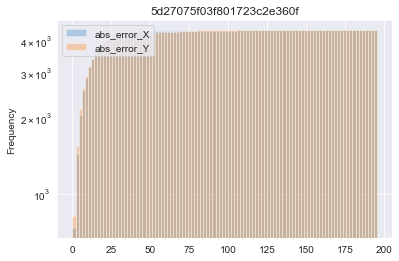

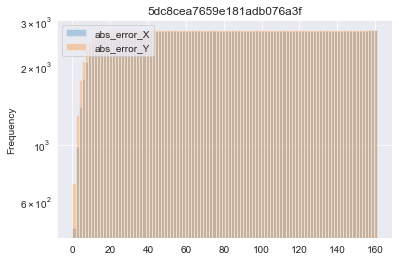

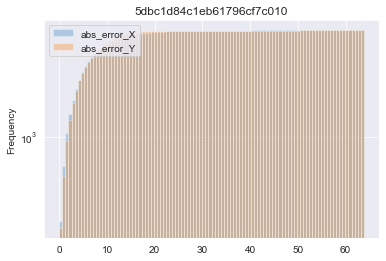

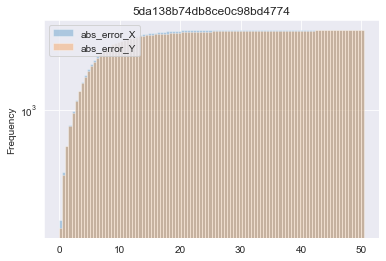

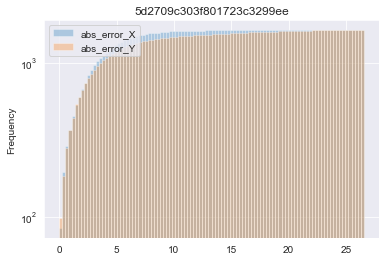

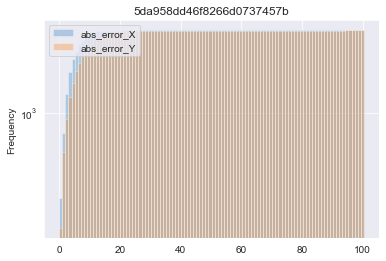

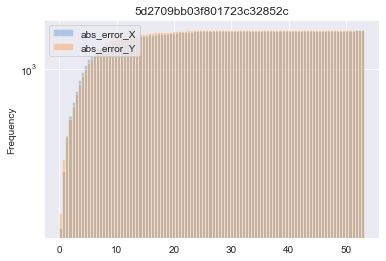

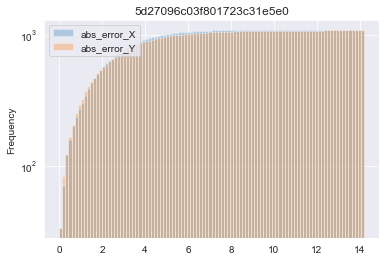

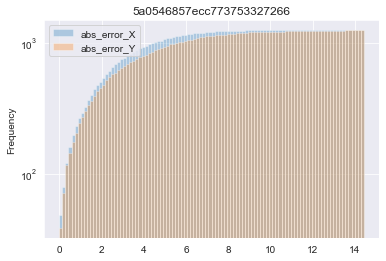

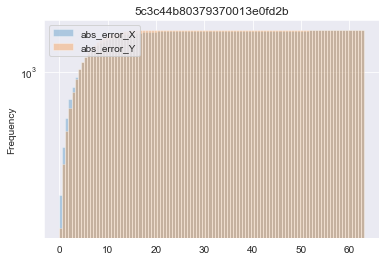

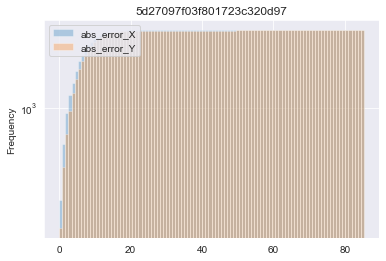

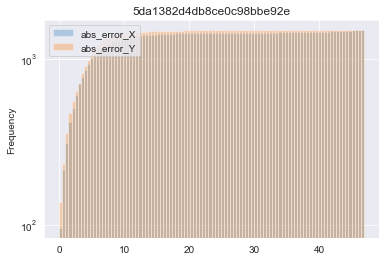

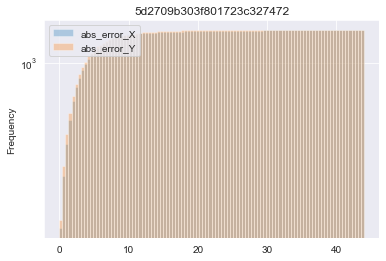

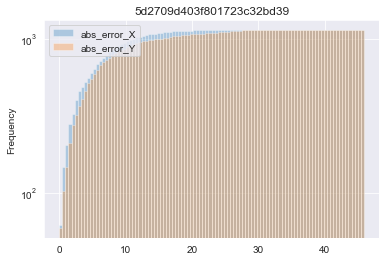

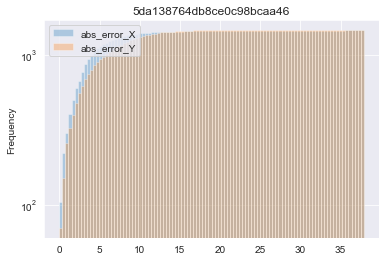

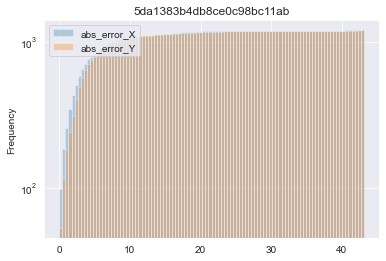

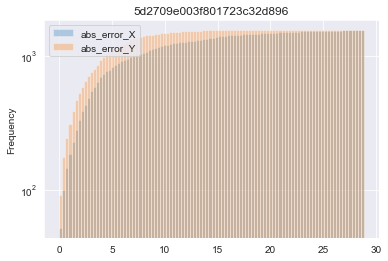

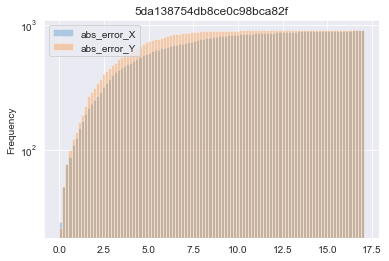

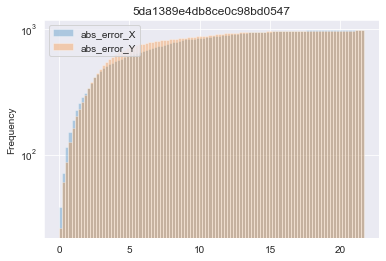

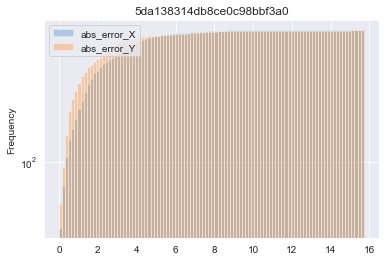

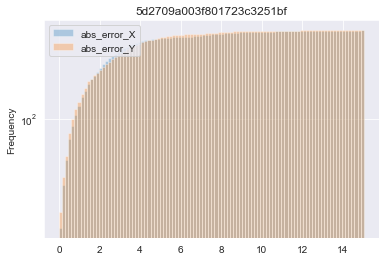

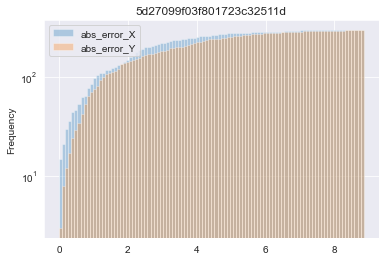

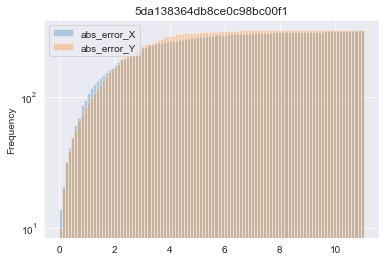

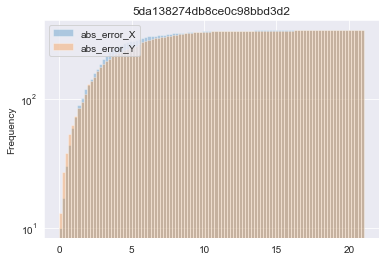

In [3]:
models24_xy = {}
train_val_comparison_xy = []
num_s = 0

site_ids_shapes = {"5d27075f03f801723c2e360f": (73141, 14063), "5dc8cea7659e181adb076a3f": (57849, 9733), "5dbc1d84c1eb61796cf7c010": (61727, 9043), "5da138b74db8ce0c98bd4774": (56668, 7075),
                   "5d2709c303f801723c3299ee": (33368, 11667), "5da958dd46f8266d0737457b": (47796, 7003), "5d2709bb03f801723c32852c": (44009, 4909), "5d27096c03f801723c31e5e0": (19337, 9933),
                   "5a0546857ecc773753327266": (26532, 6799), "5c3c44b80379370013e0fd2b": (29359, 6131), "5d27097f03f801723c320d97": (35121, 4985), "5da1382d4db8ce0c98bbe92e": (28975, 5729),
                   "5d2709b303f801723c327472": (32449, 3831), "5d2709d403f801723c32bd39": (23545, 4283), "5da138764db8ce0c98bcaa46": (27771, 3781), "5da1383b4db8ce0c98bc11ab": (34396, 3055),
                   "5d2709e003f801723c32d896": (29752, 2623), "5da138754db8ce0c98bca82f": (13795, 3259), "5da1389e4db8ce0c98bd0547": (17795, 2047), "5da138314db8ce0c98bbf3a0": (13122, 2429),
                   "5d2709a003f801723c3251bf": (9345, 2509), "5d27099f03f801723c32511d": (9700, 1855), "5da138364db8ce0c98bc00f1": (5555, 1649), "5da138274db8ce0c98bbd3d2": (6338, 985)}

site_ids_06 = ["5d27097f03f801723c320d97", "5da1389e4db8ce0c98bd0547"]
site_ids_08 = ["5d27075f03f801723c2e360f"]

site_ids = ["5da1389e4db8ce0c98bd0547"]  # "5d27097f03f801723c320d97"  "5da1389e4db8ce0c98bd0547" "5d27075f03f801723c2e360f"

for site_id in site_ids_shapes.keys(): #site_ids:#site_ids_num_bddsid.keys(): #site_ids:
    keras.backend.clear_session()
    num_s += 1
    print(f"Working on #{num_s}: Site-{site_id}")

    #========================================================================================       
    f_list, scaler_xy, encoder_xy, train_x, val_x, train_y_x, train_y_y, val_y_x, val_y_y = preprocess_data(load_data(site_id, 10000),
                                                                                                            data_fraction=1, random_state=123,
                                                                                                            delay_lim=1000, rssi_lim=-94)
    train_y_xy = np.stack([train_y_x, train_y_y], axis=1)
    val_y_xy = np.stack([val_y_x, val_y_y], axis=1)

    model_xy = DNN(site_id=site_id,
                   train_x=train_x, val_x=val_x,
                   train_y=train_y_xy, val_y=val_y_xy,
                   w_f=0.3, 
                   drop=0.3, learning_rate=round(50/site_ids_shapes[site_id][0], 4), epochs=200, batch=0)

    models24_xy[site_id] = [f_list, scaler_xy, encoder_xy, model_xy]

    #========================================================================================
    # sanity check section
    predict_columns = ["predict_X", "predict_Y"]
    real_columns = ["real_X", "real_Y"]
    col_dic = {0: "_X", 1: "_Y"}

    predictions_train_xy = pd.DataFrame(model_xy.predict(train_x), columns=predict_columns)
    comparison_train_xy = pd.concat([pd.DataFrame(train_y_xy, columns=real_columns),
                                  predictions_train_xy], axis=1)
    predictions_val_xy = pd.DataFrame(model_xy.predict(val_x), columns=predict_columns)
    comparison_val_xy = pd.concat([pd.DataFrame(val_y_xy, columns=real_columns),
                                predictions_val_xy], axis=1)

    for col_i, col in enumerate(predict_columns):
        for train_valid in [comparison_train_xy, comparison_val_xy]:
            train_valid["abs_error"+col_dic[col_i]] = np.abs(train_valid[real_columns[col_i]] - train_valid[col])

    for train_valid in [comparison_train_xy, comparison_val_xy]:
        mean_error = np.sqrt(np.power(train_valid["abs_error_X"], 2) + np.power(train_valid["abs_error_Y"], 2))
        train_valid["mean_abs_error"] = mean_error.cumsum()/train_valid.shape[0]

    print(f"Predictions (train/validation) #{num_s}: Site-{site_id}")
    #display(comparison_train_xy[["mean_abs_error"]].tail(1))
    #display(comparison_val_xy[["mean_abs_error"]].tail(1))

    train_val_comparison_xy.append([comparison_train_xy, comparison_val_xy])
    #========================================================================================
    display(comparison_val_xy.describe())
    display(comparison_val_xy[(comparison_val_xy.abs_error_X > 20) | (comparison_val_xy.abs_error_Y > 20)])

    comparison_val_xy[["abs_error_X", "abs_error_Y"]].plot.hist(cumulative=True, bins=100, logy=True, alpha=0.3, title=site_id)
    
    keras.backend.clear_session()       
    #break
print("Finished fitting")
calculate_global_metrics(train_val_comparison_xy)
save_models(models24_xy, f"models24_v6_FcatMR_fix")
print("Finished Models Saving")
#%tensorboard --logdir log/Neurals  # commandline to start tensorboard